In [3]:
import joblib
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader

from dataset import CircleImageDataset
from model import CNN
from utils import CircleParams, iou, show_circle
from metrics import thresholded_iou

In [4]:
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

#### Load the scaler

In [5]:
img_transform = joblib.load('training_checkpoints/img_transform.joblib')

#### Load the dataset

In [7]:
test_dataset = CircleImageDataset(fixed=True, max_noise=0.5, img_transform=img_transform, device=device)
test_dataloader = DataLoader(test_dataset)

#### Load the model

In [12]:
net = CNN()
net.load_state_dict(torch.load('training_checkpoints/best_epoch.pt'))
net.to(device)
net.eval()

CNN(
  (conv1): Conv2d(1, 16, kernel_size=(6, 6), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(6, 6), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(6, 6), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(6, 6), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1152, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=16, bias=True)
  (fc5): Linear(in_features=16, out_features=3, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (relu): ReLU()
  (leaky_relu): LeakyReLU(negative_slope=0.01)
  (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)

#### Get predictions

In [23]:
imgs = []
actual_circles = []
predicted_circles = []
for i, (img, circle) in enumerate(test_dataloader):
    circle = circle.squeeze()
    actual_circle = test_dataset.circle_transform.inverse_transform(
        CircleParams(radius=circle[0].item(), col=circle[1].item(), row=circle[2].item()))
    actual_circles.append(actual_circle)

    y = net(img)

    rad_mu = y[:, 0].squeeze() # Radius mean
    col_mu = y[:, 1].squeeze() # Col mean
    row_mu = y[:, 2].squeeze() # Row mean
    
    predicted_circle = test_dataset.circle_transform.inverse_transform(
        CircleParams(radius=rad_mu.item(), row=row_mu.item(), col=col_mu.item()))
    predicted_circles.append(predicted_circle)

    imgs.append(img.detach().cpu().numpy().reshape(100, 100))

#### Calculate metrics

In [24]:
print(r"% above 0.5 IOU", thresholded_iou(actual_circles, predicted_circles, thresh=0.5))
print(r"% above 0.75 IOU", thresholded_iou(actual_circles, predicted_circles, thresh=0.75))
print(r"% above 0.9 IOU", thresholded_iou(actual_circles, predicted_circles, thresh=0.9))

% above 0.5 IOU 0.99
% above 0.75 IOU 0.94
% above 0.9 IOU 0.54


#### Visualize Predictions

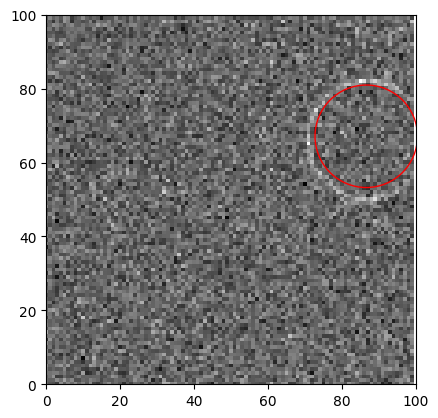

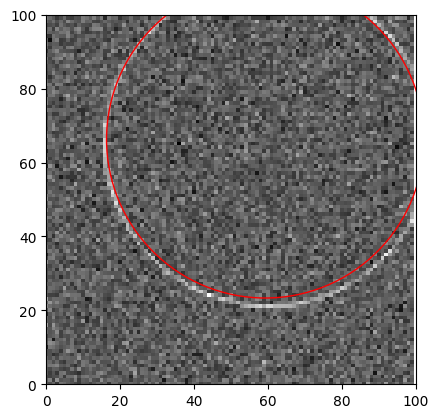

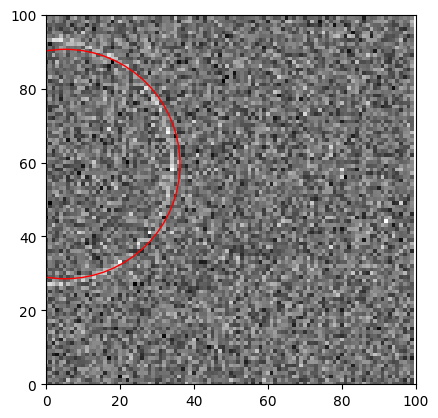

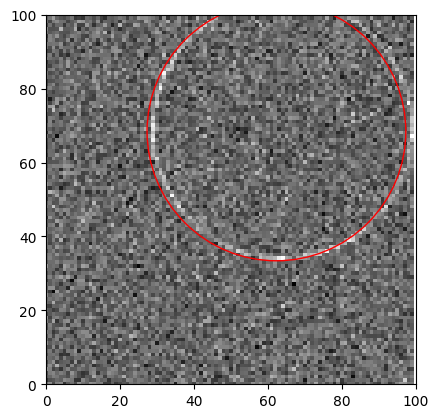

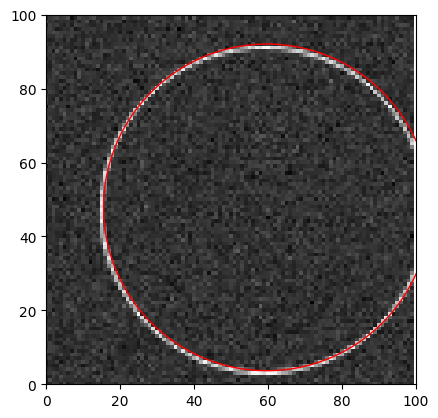

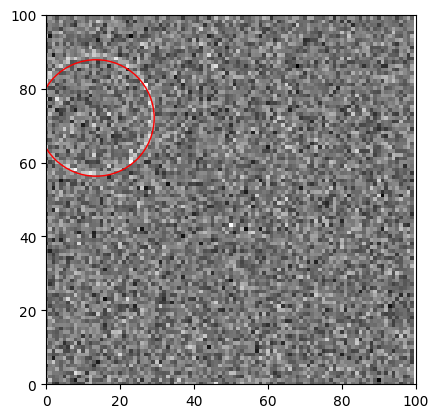

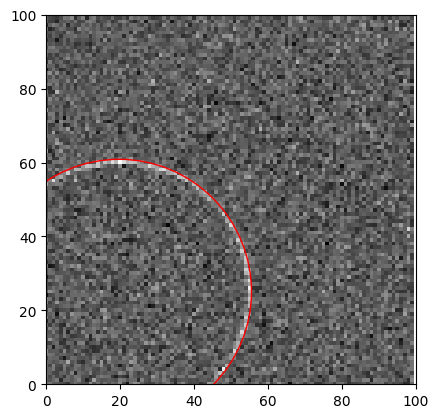

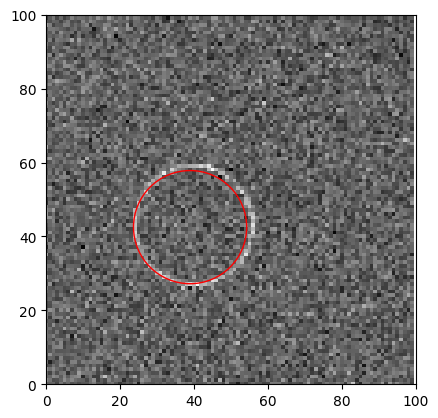

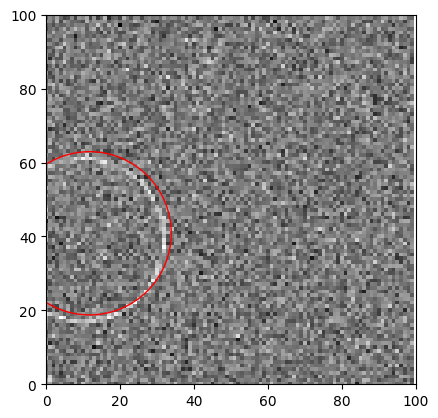

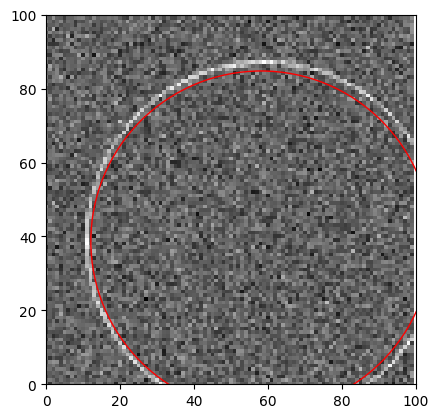

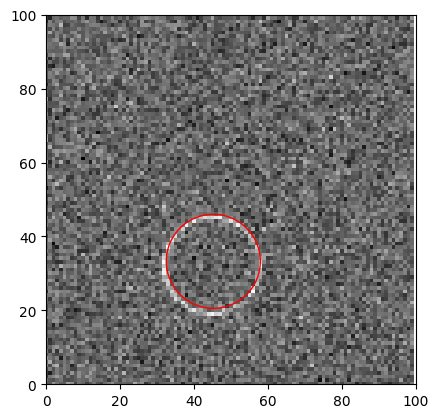

In [28]:
for i, (img, predicted_circle, actual_circle) in enumerate(zip(imgs, predicted_circles, actual_circles)):
    fig, ax = plt.subplots()

    ax.imshow(img, cmap="gray")

    # actual_patch = patches.Circle((actual_circle.col, actual_circle.row), actual_circle.radius, fill=False, edgecolor='blue')
    # ax.add_patch(actual_patch)

    predicted_patch = patches.Circle((predicted_circle.col, predicted_circle.row), predicted_circle.radius, fill=False, edgecolor='red')
    ax.add_patch(predicted_patch)

    ax.set_xlim(0, 100)
    ax.set_ylim(0, 100)
    ax.set_aspect('equal')

    # Show the plot
    plt.show()
    if i == 10:
        break